# Visu 10: Compare focus

Compare the profile based on the focus of the picture for two images and several segments

## Setup

In [3]:
import os
import matplotlib.pyplot as plt
import random
import imageio
import numpy as np
from skimage.measure import profile_line

In [4]:
from amftrack.util.geometry import (
    compute_factor,
    expand_segment,
    generate_index_along_sequence,
)
from amftrack.util.image_analysis import convert_to_micrometer
from amftrack.util.sys import storage_path
from amftrack.ml.width.make_dataset import fetch_labels

In [5]:
dataset_directory = os.path.join(storage_path, "labels_focus", "Image1")

## Fetch labels

In [6]:
def reverse(segment):
    return [[segment[0][1], segment[0][0]], [segment[1][1], segment[1][0]]]

In [7]:
segment_labels = fetch_labels(dataset_directory)

In [8]:
segment_labels

{'Capture0002.tif': [[[2359.9, 2048.4], [2362.6, 2048.1]],
  [[2588.6, 1970.3], [2588.9, 1973.6]],
  [[2383.6, 2130.1], [2386.1, 2128.9]],
  [[1568.4, 1583.0], [1570.8, 1583.1]],
  [[1540.0, 1837.8], [1542.6, 1839.2]],
  [[672.8, 1578.5], [673.4, 1582.1]],
  [[2416.7, 1617.0], [2415.9, 1620.1]],
  [[3163.5, 1542.2], [3164.4, 1544.1]],
  [[2674.0, 2165.5], [2674.6, 2167.2]]]}

In [9]:
segments = [reverse(segment) for segment in segment_labels['Capture0002.tif']]

In [10]:
focus_title = {0: "Out of focus: -0.2 mm", 1:"Acceptable focus: -0.1 mm", 2:"Optimal focus", 3:"Prince focus: +0.1 mm", 4:"Prince focus: +0.2 mm", 5:"Out of focus: +0.3 mm"}

## Extract all slices for one segment

Get paths of all images

In [11]:
slices = []
image_paths = []
for image_name in os.listdir(dataset_directory):
    if ".tif" in image_name:
        image_path = os.path.join(dataset_directory, image_name)
        image_paths.append(image_path)

Fetch segments

In [12]:
def show_image(i, segment):
    im = imageio.imread(image_paths[i])
    fig = plt.figure(figsize=(15, 10))
    plt.imshow(im)
    plt.plot(segment[0][1], segment[0][0], marker="x", color="red")
    plt.plot(segment[1][1], segment[1][0], marker="x", color="red")

In [13]:
def get_slices(segment):

    target_length = 120

    point1 = np.array(segment[0])
    point2 = np.array(segment[1])
    middle_point = (point1 + point2) / 2
    # Compute width
    width = convert_to_micrometer(
        np.linalg.norm(point1 - point2), magnification=2
    )
    point1_, point2_ = expand_segment(
            point1, point2, factor=compute_factor(point1, point2, target_length)
        )
    # Fetch segment in all the images
    slices = []
    ims = []
    for path in image_paths:
        im = imageio.imread(path)
        ims.append(im)
        profile = profile_line(im, point1_, point2_, mode="constant")
        profile = profile[:target_length]
        profile = profile.reshape((1, len(profile)))
        slices.append(profile)
    slice_array = np.concatenate(slices, axis=0)
    
    return slice_array, width

## Visualisation

### Small hypha

In [14]:
choice = 8

In [16]:
segment = segments[choice]
slice_array, width = get_slices(segment)

In [246]:
width

3.109787975087343

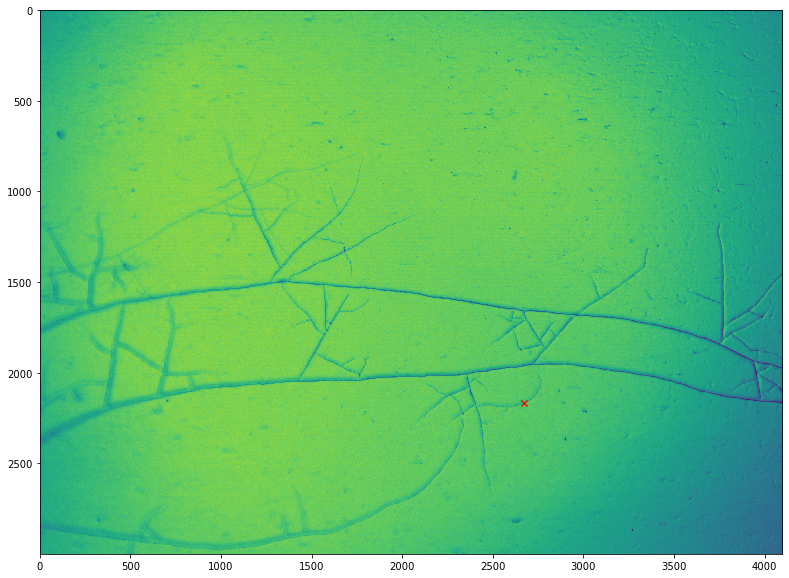

In [247]:
show_image(2, segment)

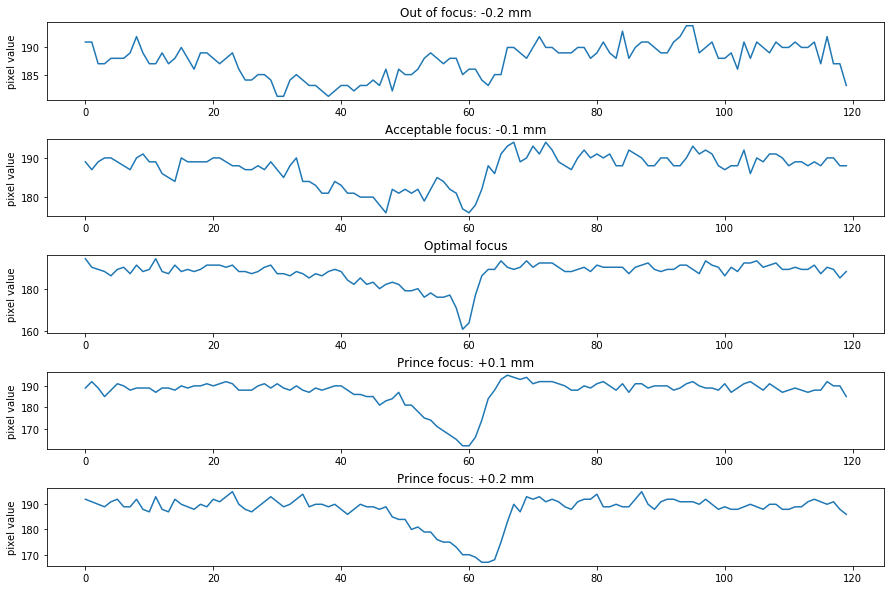

In [248]:
fig = plt.figure(figsize=(15, 10))
for i,j in enumerate([0, 1, 2, 3, 4]):
    plt.subplot(5, 1, i+1)
    plt.ylabel("pixel value")
    plt.title(focus_title[i])
    plt.plot(slice_array[j,:])
plt.subplots_adjust(hspace = 0.5)

### Medium hypha

In [252]:
choice = 1

In [253]:
segment = segments[choice]
slice_array, width = get_slices(segment)

In [254]:
width

5.715974326394358

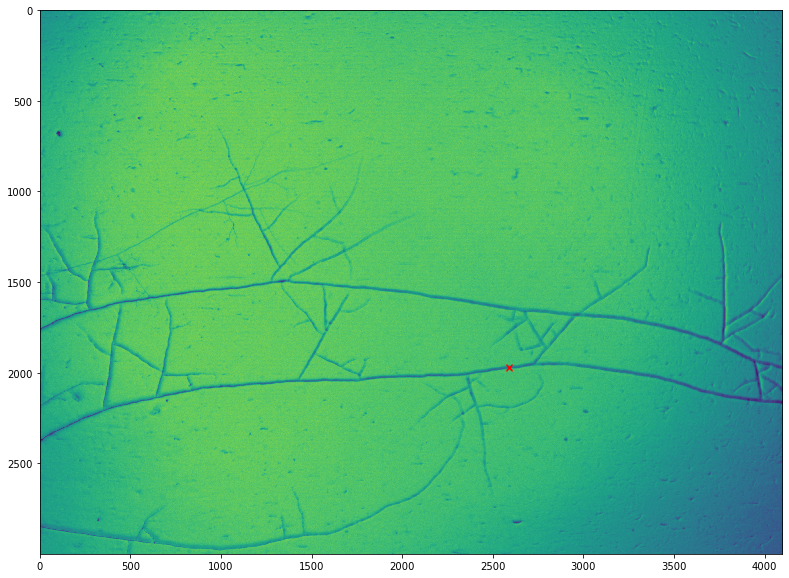

In [255]:
show_image(4, segment)

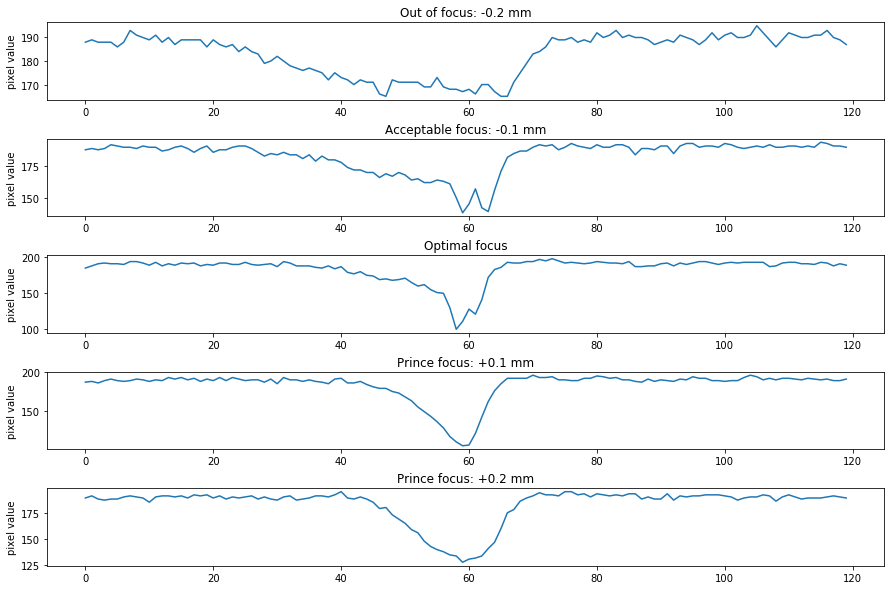

In [256]:
fig = plt.figure(figsize=(15, 10))
for i,j in enumerate([0, 1, 2, 3, 4]):
    plt.subplot(5, 1, i+1)
    plt.ylabel("pixel value")
    plt.title(focus_title[i])
    plt.plot(slice_array[j,:])
plt.subplots_adjust(hspace = 0.5)

### Other hypha

In [257]:
choice = 7

In [258]:
segment = segments[choice]
slice_array, width = get_slices(segment)

In [259]:
width

3.6266048171807945

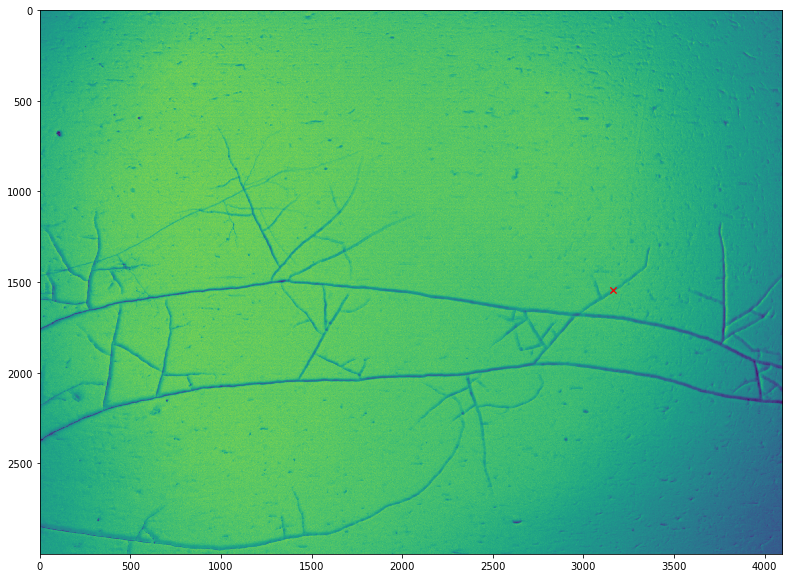

In [260]:
show_image(4, segment)

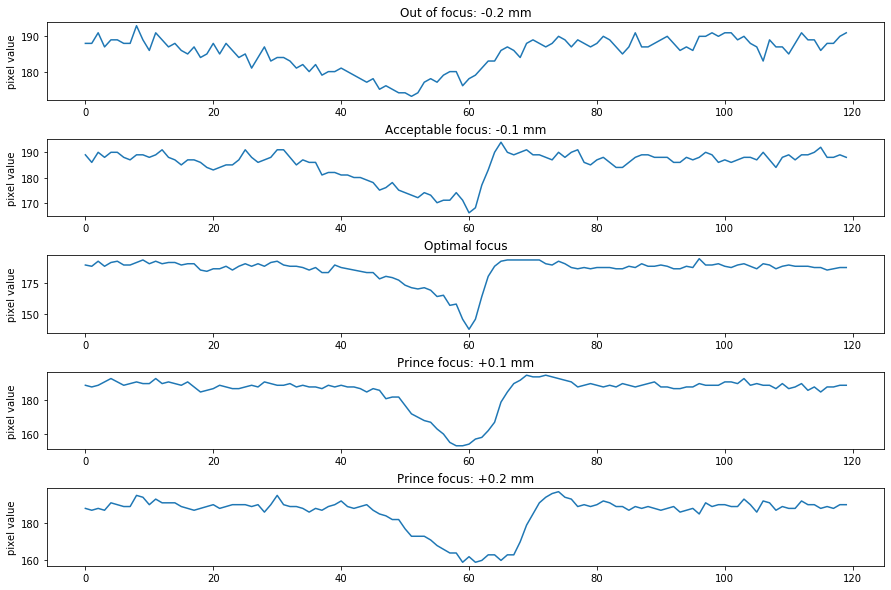

In [262]:
fig = plt.figure(figsize=(15, 10))
for i,j in enumerate([0, 1, 2, 3, 4]):
    plt.subplot(5, 1, i+1)
    plt.ylabel("pixel value")
    plt.title(focus_title[i])
    plt.plot(slice_array[j,:])
plt.subplots_adjust(hspace = 0.5)

## Trying out a model

In [1]:
import os
import matplotlib.pyplot as plt
import random
import imageio
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold

from amftrack.util.sys import storage_path
from amftrack.ml.width.models import first_model
from amftrack.ml.width.data_augmentation import data_augmentation

2022-06-01 11:40:14.704303: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-01 11:40:14.704320: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/ipausers/kahane/Wks/AMFtrack/amftrack/util/dbx.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2022-06-01 11:40:22.310805: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ipausers/kahane/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-06-01 11:40:22.310845: W tensorflow/stream_executor/c

In [17]:
save_path = os.path.join(storage_path, "models", "model_test")
model = keras.models.load_model(save_path)

### Small hypha

In [32]:
choice = 8
segment = segments[choice]
slice_array, width = get_slices(segment)

In [33]:
slice_array

array([[191., 191., 187., ..., 187., 187., 183.],
       [189., 187., 189., ..., 190., 188., 188.],
       [194., 190., 189., ..., 189., 185., 188.],
       ...,
       [190., 189., 189., ..., 187., 190., 184.],
       [192., 190., 189., ..., 190., 190., 184.],
       [192., 191., 186., ..., 188., 187., 183.]])

In [34]:
slice_array.shape

(13, 120)

In [35]:
model.predict(slice_array[:5])

array([[3.688037 ],
       [3.5691042],
       [3.5326939],
       [3.9464543],
       [3.6364532]], dtype=float32)

In [36]:
width

3.109787975087343

### Medium

In [38]:
choice = 1
segment = segments[choice]
slice_array, width = get_slices(segment)

In [39]:
width

5.715974326394358

In [40]:
slice_array

array([[188., 189., 188., ..., 190., 189., 187.],
       [188., 189., 188., ..., 191., 191., 190.],
       [184., 187., 190., ..., 187., 190., 188.],
       ...,
       [189., 191., 191., ..., 190., 190., 190.],
       [192., 189., 189., ..., 188., 189., 192.],
       [190., 190., 187., ..., 192., 189., 189.]])

In [41]:
slice_array.shape

(13, 120)

In [42]:
model.predict(slice_array[:5])

array([[4.0550942],
       [4.5713396],
       [6.205876 ],
       [5.7251062],
       [4.536749 ]], dtype=float32)

In [43]:
width

5.715974326394358